# Seaweed-growth plotting

This notebook aims to explore the seaweed-growth model and its temporal & geospational plotting

### Imports

In [11]:
import datetime
from ocean_navigation_simulator.environment.Arena import Arena
from ocean_navigation_simulator.environment.PlatformState import PlatformState, SpatialPoint
from ocean_navigation_simulator.utils import units

### Parameters

In [12]:
platform_dict = {
    'battery_cap_in_wh': 400.0,
    'u_max_in_mps': 0.1,
    'motor_efficiency': 1.0,
    'solar_panel_size': 0.5,
    'solar_efficiency': 0.2,
    'drag_factor': 675,
    'dt_in_s': 600,
    'use_geographic_coordinate_system': True,
}
casadi_cache_dict = {'deg_around_x_t': 1, 'time_around_x_t': 3600 * 24 * 3}
solar_source_dict = {
    'field': 'SolarIrradiance',
    'source': 'analytical_wo_caching',
    'source_settings': {
        'boundary_buffers': [0.2, 0.2],
        'x_domain': [-180, 180],
        'y_domain': [-90, 90],
        'temporal_domain': [datetime.datetime(2020, 1, 1, 0, 0, 0, tzinfo=datetime.timezone.utc),
                            datetime.datetime(2023, 1, 10, 0, 0, 0, tzinfo=datetime.timezone.utc)],
        'spatial_resolution': 0.1,
        'temporal_resolution': 3600,
    }
}
# Set Seaweed Model dict
seaweed_source_dict = {
    'field': 'SeaweedGrowth',
    'source': 'GEOMAR',
    'source_settings': {
        'filepath': '../../../data/nutrients/2021_monthly_nutrients_and_temp.nc',
    }
}
ocean_source_dict = {'field': 'OceanCurrents',
                     'source': 'opendap',
                     'source_settings': {
                         'service': 'copernicus',
                         'currents': 'total',
                         # if we want to take the normal uo, vo currents or 'total' for tide, normal added
                         'USERNAME': 'mmariuswiggert', 'PASSWORD': 'tamku3-qetroR-guwneq',
                         # 'DATASET_ID': 'global-analysis-forecast-phy-001-024-hourly-t-u-v-ssh',
                         'DATASET_ID': 'cmems_mod_glo_phy_anfc_merged-uv_PT1H-i'}}

### Arena

In [13]:
arena = Arena(
    casadi_cache_dict=casadi_cache_dict,
    platform_dict=platform_dict,
    ocean_dict={'hindcast': ocean_source_dict, 'forecast': None},
    solar_dict={'hindcast': solar_source_dict, 'forecast': None},
    seaweed_dict={'hindcast': seaweed_source_dict, 'forecast': None},
    use_geographic_coordinate_system=platform_dict['use_geographic_coordinate_system']
)

### Prepare Plot

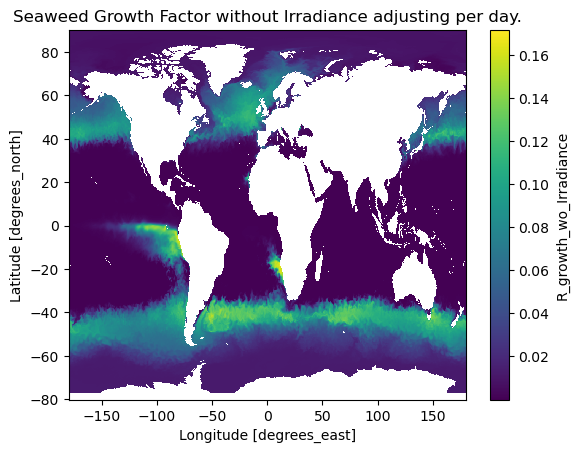

In [14]:
# %% Plot plot_R_growth_wo_Irradiance (what it calculates at the start)
platform_state = PlatformState(lon=units.Distance(deg=-50),
                               lat=units.Distance(deg=-40),
                               date_time=datetime.datetime(year=2021, month=11, day=20, hour=19, minute=0, second=0,
                                                           tzinfo=datetime.timezone.utc))
arena.seaweed_field.hindcast_data_source.plot_R_growth_wo_Irradiance(platform_state.date_time)


# %% The growth at the platform_state if the sun shines as at that time for 12h
arena.seaweed_field.hindcast_data_source.set_casadi_function()
arena.seaweed_field.hindcast_data_source.F_NGR_per_second(platform_state.to_spatio_temporal_casadi_input()) * 12 * 3600
# %% get the data over an area (e.g. for hj_reachability or when we implement caching)
x_interval = [-150, 150]
y_interval = [-60, 60]
t_interval = [datetime.datetime(2021, 1, 1, 0, 0, 0, tzinfo=datetime.timezone.utc),
              datetime.datetime(2021, 1, 3, 23, 0, 0, tzinfo=datetime.timezone.utc)]
temporal_res = 3600 * 3
spatial_res = 5

### Plotting

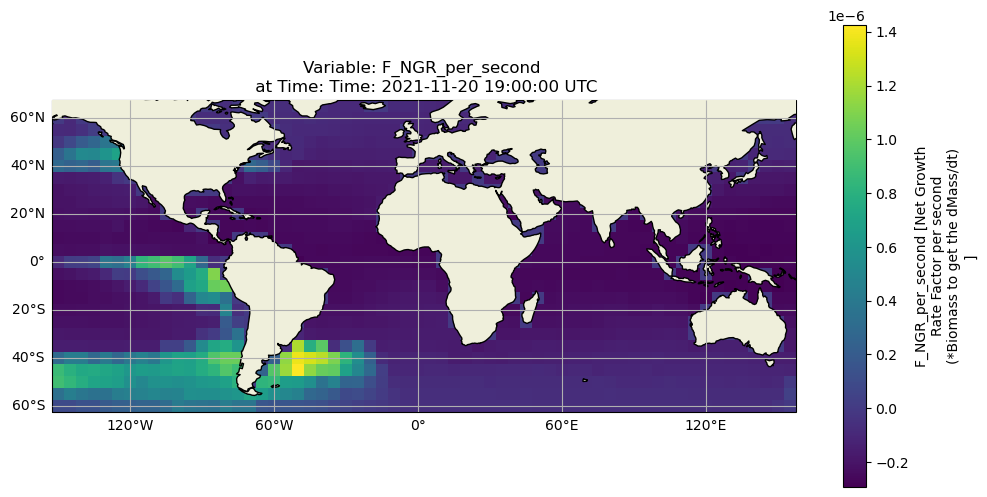

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1200x600', '-pix_fmt', 'rgba', '-r', '10', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'generated_media/growth_animation.mp4']' died with <Signals.SIGKILL: 9>.

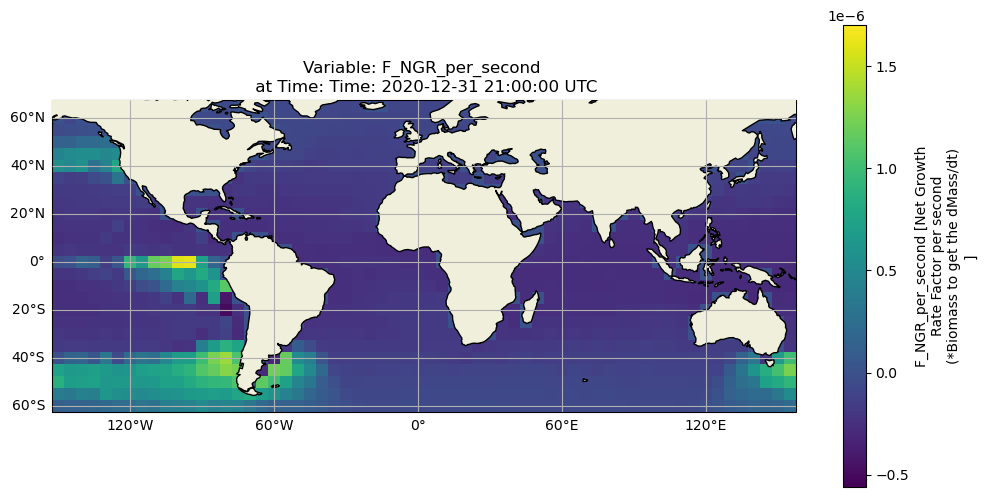

In [18]:
# %% Plot data at time over area
arena.seaweed_field.hindcast_data_source.plot_data_at_time_over_area(
    time=platform_state.date_time, x_interval=x_interval, y_interval=y_interval, return_ax=False,
    spatial_resolution=spatial_res, figsize=(12, 6))
# %% animate data over time and area
arena.seaweed_field.hindcast_data_source.animate_data(x_interval=x_interval, y_interval=y_interval,
                                                      t_interval=t_interval,
                                                      temporal_resolution=temporal_res, spatial_resolution=spatial_res,
                                                      output="growth_animation.mp4", figsize=(12, 6))
